In [2]:
import os
import sys
from datetime import datetime
import glob

sys.path.append(r'./tools/align')
sys.path.append(r'./tools/geolocation_grid')



In [3]:
from AlignSAR import *

### Transforming model displacement data into projection of tiff image - 3966 (move it to model_drift_export notebook)

In [33]:
#export of reprojected drift
from LocationMapping import LocationMapping
img1_path=r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'
displacement_path=r'/home/jovyan/data/model_data_process_output/hourly_cumulative_drift_csv/drift_lon2_lat2/hourly_ice_displacement_20221120T09_lon2lat2.csv'
image1 = gdal.Open(str(img1_path))

with open(displacement_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)
            
lm1 = LocationMapping(image1.GetGeoTransform(), image1.GetProjection())
displacements = displacements[~np.any(np.isnan(displacements), axis=1), :]
displacements = displacements[~np.any(np.isinf(displacements), axis=1), :]
orig_locs = displacements[:, [0, 1]] 
new_locs = displacements[:, [2, 3]]                

#swapped references to original and new coordinated columns as gdal swap coordinates while processing. 
y1, x1 = lm1.mapFromCoords2Proj( orig_locs[:,1].reshape( (-1) ), orig_locs[:,0].reshape( (-1) ) )
y2, x2 = lm1.mapFromCoords2Proj( new_locs[:,1].reshape( (-1) ), new_locs[:,0].reshape( (-1) ) )
dx = x2 - x1
dy = y2 - y1

[-248487.61829314 -246224.85196304 -243962.01197043 ...  382410.12795377
  384677.01383337  386944.0345087 ] [-1200727.33567686 -1201763.41200213 -1202797.1437475  ...
  -926627.1244491   -927630.24194831  -928633.30891533] [2897.07785435 2899.01187782 2900.82603413 ...    0.            0.
    0.        ] [-11440.44304695 -11436.59083978 -11430.49120978 ...      0.
      0.              0.        ]


In [34]:
output_dir = r'/home/jovyan/data/model_data_process_output/cum_drift_3996_csv'

points=zip(x1, y1, dx, dy)
header=['x','y', 'dx','dy']

#Create CSV file for every displacement

file_name = f'cum_ice_displacement_dxdy.csv'
file_path = os.path.join(output_dir, file_name)


#Open the CSV file for writing              
with open(file_path, 'w', newline='') as csv_file:
    out = csv.writer(csv_file, delimiter=',')
    out.writerow(header)
    out.writerows(points)

### For single input file

For example, to run algorithm once for one csv file with cumulative (integrated) drift.
* If results doesn't make sense, it might be a problem with gdal version.
Install a different version or go to ./tools/geolocation_grid/LocationMapping.py and swap x and y in latLon2Raster function in 'self.mapFromProj2Raster(y, x )

##### For SAR1 -> SAR2 using model subset drift

In [ ]:
%%time
a = Alignment(img1_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              img2_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              displacement_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/12_14_feb/barents_model_24ens_cum_disp_for_chalmers.csv',
              out_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model/',
              geocoded=True)



Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
Done.


Estimating piecewise-affine transformation...
Done.

Warping /home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif
A new name of the file is /home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model//Forecasted_um_disp_for_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif


##### For SAR1 -> SAR2 using algorithm drift (after filtering with gpi)

In [ ]:
%%time
a = Alignment(img1_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              img2_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              displacement_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/12_14_feb/barents_alg_disp_for_chalmers_14-16feb_gpi.csv',
              out_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_alg_gpi/',
              geocoded=True)



##### For SAR1 -> SAR2 using algorithm drift (full)

In [5]:
%%time
a = Alignment(img1_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              img2_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV.tif',
              displacement_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/12_14_feb/barents_alg_disp_for_chalmers_14-16feb.csv',
              out_path=r'/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_algorithm/',
              geocoded=True)



Alignment method: piecewise-affine


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'

### Running in batch for image-driven approach

(use as input every new forecasted image)

In [ ]:
# Set paths to folders
csv_folder = r'/home/jovyan/data/model_data_process_output/hourly_cumulative_drift_csv/drift_lon2_lat2/hourly_ice_displacement_20221120T09_lon2lat2.csv'
tiff_folder = r'/home/jovyan/data/SAR_images_forecast/'

In [5]:
#Create a list of input tif files. At first, it's only one file
tif_files = glob.glob(os.path.join(tiff_folder, '*.tif'))
tif_files = sorted(tif_files, key=lambda x: os.path.getctime(os.path.join(tiff_folder, x)))
#Create a list of all csv files with drift from input folder
csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))
#sort according to the date and time specified at the end of the file name and before .csv
csv_files = sorted(csv_files, key=lambda x: datetime.strptime(x[-15:-4], '%Y%m%dT%H'))
#csv_files = sorted(os.listdir(csv_folder), key=lambda x: datetime.strptime(x[-15:-4], '%Y%m%dT%H'))
tif_files[-1]

'C:\\Anna\\Icedrift\\Special_curriculum\\19-20_subset_experiment\\model_drift\\integrated_lambert\\Aligned_sar\\subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'

In [6]:
for i, file in enumerate(csv_files):
    if i == 0:
        print("already done")
    else:
        print(file)

already done


In [ ]:
#Version which work but it contains two separate modules
#First to run on the original one image, then on each new forecasted ones

In [17]:
%%time
#1) i == 0

#set general parameters for the forecast
img2_path=r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
#Set outpath the same as input so all tiff would be saved in obe folder for further animation
out_path = tiff_folder

for i, file in enumerate(csv_files):
    if i == 0:
        #Runs forecast algortihm on the original tif for the first csv file
        img1_path = tif_files[0]
        displacement_path = os.path.join(csv_folder, csv_files[i])
        #print(i, displacement_path)
        
        a = Alignment(img1_path = img1_path,
                      img2_path = img2_path, 
                      displacement_path = displacement_path,
                      out_path = out_path, 
                      geocoded=True)
        print(f"Forecast for csv file number {i+1} completed")
    else:
        pass

Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
77.32247924804688 -11.801506996154785
wow3 -1385342.1764432844 -248487.6932314939
wow4 -3417.607318885532 -4228.7199519054675
77.32247924804686 -11.795346710832023
wow3 -1385342.1764432858 -248421.7401339251
wow4 -3415.958491446312 -4224.118165515657
Done.


Estimating piecewise-affine transformation...
Done.

Warping C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\iterative_lambert\Aligned_sar\subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
A new name of the file is C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\iterative_lambert\Aligned_sar/Aligned_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
Alignment finished in 91.2 minutes

Alignment for csv file number 1 completed
CPU times: total: 1h 23min 29s
Wall time: 1h 31min 12s


In [18]:
%%time
#2) i > 0

#set general parameters for alignment
img2_path=r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
#Set outpath the same as input so all tiff would be saved in obe folder for further animation
out_path = tiff_folder

for i, file in enumerate(csv_files):
    if i == 0:
        print("already done")

    if i > 0:

        #First, update a list of tif files. I use this as I don't know how to get output out of Denis's class to append it to the list
        tif_files = glob.glob(os.path.join(tiff_folder, '*.tif'))

        #sorting the list by creation time. if I would just append, I'd use tif_files[-1] immidiatly
        tif_files = sorted(tif_files, key=Zlambda x: os.path.getctime(os.path.join(tiff_folder, x)))
        print(f"Tiff folder now contains {len(tif_files)} files")

        #Using the last created aligned tif file from the list     
        img1_path = tif_files[-1]
        displacement_path = os.path.join(csv_folder, csv_files[i])
        
        a = Alignment(img1_path = img1_path,
              img2_path = img2_path,
              displacement_path = displacement_path,
              out_path = out_path,
              geocoded=True)
        print(f"Alignment for csv file number {i+1} completed")


already done
Tiff folder now contains 2 files
Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
77.32247924804688 -11.801506996154785
wow3 -1385342.1764432844 -248487.6932314939
wow4 -3417.607318885532 -4228.7199519054675
77.32247924804686 -11.79171078651359
wow3 -1385342.1764432858 -248384.1500597709
wow4 -3415.018739592457 -4221.323741850028
Done.


Estimating piecewise-affine transformation...
Done.

Warping C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\iterative_lambert\Aligned_sar\Aligned_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
A new name of the file is C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\iterative_lambert\Aligned_sar/Aligned_20221119T09_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
Alignment finished in 90.3 minutes

Alignment for csv file number 2 completed
Tiff 

### Version which for some reason doesn't work (but try to run again.

In [ ]:
#I checnged ALign.py and now it names first files without "Aligned" in the beginning and just then with

#set general parameters for alignment
img2_path = r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\ensemble_experiment\sar2\subset_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif' #have to set it as alignment asks for it
#Set outpath the same as input so all tiff would be saved in obe folder for further animation
out_path = tiff_folder

for i, file in enumerate(csv_files):
    if i == 0:
        #Runs alignment algortihm on the original tif for the first csv file
        img1_path = tif_files[0]
        displacement_path = os.path.join(csv_folder, csv_files[i])
        #print(i, displacement_path)
        
        a = Alignment(img1_path = img1_path,
                      img2_path = img2_path, 
                      displacement_path = displacement_path,
                      out_path = out_path, 
                      geocoded=True)
        print(f"Alignment for csv file number {i+1} completed")

    if i > 0:

        #First, update a list of tif files. I use this as I don't know how to get output out of Denis's class to append it to the list
        tif_files = glob.glob(os.path.join(tiff_folder, '*.tif'))

        #sorting the list by creation time. if I would just append, I'd use tif_files[-1] immidiatly
        tif_files = sorted(tif_files, key=lambda x: os.path.getctime(os.path.join(tiff_folder, x)))
        print(f"Tiff folder now contains {len(tif_files)} files")

        #Using the last created aligned tif file from the list     
        img1_path = tif_files[-1]
        displacement_path = os.path.join(csv_folder, csv_files[i])
        
        a = Alignment(img1_path = img1_path,
              img2_path = img2_path,
              displacement_path = displacement_path,
              out_path = out_path,
              geocoded=True)
        print(f"Alignment for csv file number {i+1} completed")

Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
79.65628051757812 -8.828641891479492
wow3 -1135617.5582795101 -152852.05443175766
wow4 -784.7163488921259 -728.8975283399841
79.65455873074836 -8.81192071532945
wow3 -1135862.735876632 -152649.2009924326
wow4 -779.6450129089994 -727.3873988878947
Done.


Estimating piecewise-affine transformation...
Done.

Warping C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\ensemble_experiment\ens8_hourly_drift\sar_images\subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
A new name of the file is C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\ensemble_experiment\ens8_hourly_drift\sar_images/Aligned_20221119T08_subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif


### For integrated (drift-driven) drift
(using as input only the original SAR1 image)

In [ ]:
%%time
#1) i == 0

#set general parameters for alignment
img1_path = r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'
img2_path=r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
#Set outpath the same as input so all tiff would be saved in obe folder for further animation
out_path = tiff_folder

for i, file in enumerate(csv_files):
        #Runs alignment algortihm on the original tif for the first csv file
        #img1_path = tif_files[0]
        displacement_path = os.path.join(csv_folder, csv_files[i])
        #print(i, displacement_path)
        
        a = Alignment(img1_path = img1_path,
                      img2_path = img2_path, 
                      displacement_path = displacement_path,
                      out_path = out_path, 
                      geocoded=True)
        print(f"Alignment for csv file number {i+1} completed")

Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
77.32247602133035 -11.801506800074447
wow3 -1385342.53240098 -248487.6182931384
wow4 -3417.6054454266446 -4228.725223841533
77.32247602133035 -11.559545533953916
wow3 -1385342.53240098 -245590.54043879098
wow4 -3345.178499067959 -3991.6580046933523
Done.


Estimating piecewise-affine transformation...
Done.

Warping C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\integrated_lambert\Aligned_sar\subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
A new name of the file is C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\model_drift\integrated_lambert\Aligned_sar/Aligned_20221120T09_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
Alignment finished in 95.5 minutes

Alignment for csv file number 1 completed
CPU times: total: 1h 29min 12s
Wall time: 1h 35min 32s


In [2]:
img1_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_1_of_subset_1_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'
img2_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_2_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
displacement_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\drift\model\subset_19-20_nov_model_lat12lon12.csv'
#displacement_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\drift\060\fltrd_CTU_drift_20191028T174022-20191031T170040.csv'
out_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\model_shift'

In [ ]:
with open(displacement_path) as csvfile:
            csvreader = csv.reader(csvfile)
            displacements = np.array([row for row in csvreader]).astype(float)

In [44]:
# Select only not NaN data for displacements
displacements = displacements[~np.any(np.isnan(displacements), axis=1), :]
orig_locs = displacements[:, [1, 0]]
new_locs = displacements[:, [3, 2]] + orig_locs

In [45]:
new_locs

array([[       inf,        inf],
       [       inf,        inf],
       [       inf,        inf],
       ...,
       [4900.52932, 2755.18578],
       [4951.09626, 2801.21019],
       [4939.09913, 2771.61271]])

In [10]:
#from LocationMapping import LocationMapping

img1_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_1_of_subset_1_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'
img2_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_2_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
image1 =gdal.Open(img1_path)
image2 =gdal.Open(img2_path)
displacement_path=r'C:\Anna\Model_data\model_output\19_20_Nov_for_aligh\subset_19-20_nov_model_lat12lon12.csv'

with open(displacement_path) as csvfile:
    csvreader = csv.reader(csvfile)
    displacements = np.array([row for row in csvreader]).astype(float)

    lm1 = LocationMapping(image1.GetGeoTransform(), image1.GetProjection())
    lm2 = LocationMapping(image2.GetGeoTransform(), image2.GetProjection())
    print('\nConvert geocoded cooridnates to raster coordinates...')
    displacements = displacements[~np.any(np.isnan(displacements), axis=1), :]
    orig_locs = displacements[:, [0, 1]] 
    new_locs = displacements[:, [2, 3]]
    
    #print("here are cordinates!", orig_locs, new_locs)
    
    c0, r0 = lm1.latLon2Raster( orig_locs[:,1].reshape( (-1) ), orig_locs[:,0].reshape( (-1) ) )
    c1, r1 = lm2.latLon2Raster( new_locs[:,1].reshape( (-1) ), new_locs[:,0].reshape( (-1) ) )
    orig_locs = np.stack((c0, r0)).T
    new_locs = np.stack((c1, r1)).T
    print(orig_locs)


Convert geocoded cooridnates to raster coordinates...
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


In [105]:
c0, r0

(array([ -34.64850695,   27.85149305,   90.35149305, ..., 1902.85149305,
        1965.35149305, 2027.85149305]),
 array([-359.64486866, -359.64486866, -359.64486866, ..., 3390.35513134,
        3390.35513134, 3390.35513134]))

In [90]:
# Open geotiff file
image = gdal.Open(str(img1_path))
# Create Location mapping
lm = LocationMapping( image.GetGeoTransform(), image.GetProjection() )
# Get lon and lat values of all pixels
X = np.arange( image.RasterXSize )
Y = np.arange( image.RasterYSize )
X, Y = np.meshgrid( X, Y )

lon, lat  = lm.raster2LatLon( X.reshape( (-1) ), Y.reshape( (-1) ) ) #changed lat and lon

In [92]:
lon = lon.reshape(image.RasterYSize,image.RasterXSize)
lat = lat.reshape(image.RasterYSize,image.RasterXSize)

x, y = lm.latLon2Raster(lat.reshape((-1)),lon.reshape((-1)))

80.13542745597685 -3.822772608567932
wow3 -1083703.0595653877 -64503.400476076
wow4 -8.440110832452775e-11 5.704350769519806e-10


In [93]:
minx = np.nanmin(x)
miny = np.nanmin(y)
np.ceil(minx), np.ceil(miny)

(-0.0, 1.0)

In [94]:
np.ceil(np.nanmax(x)),np.ceil(np.nanmax(y))

(2960.0, 2960.0)

In [104]:
u, v = 

2960

(-3.822772608567932, 80.13542745597685)

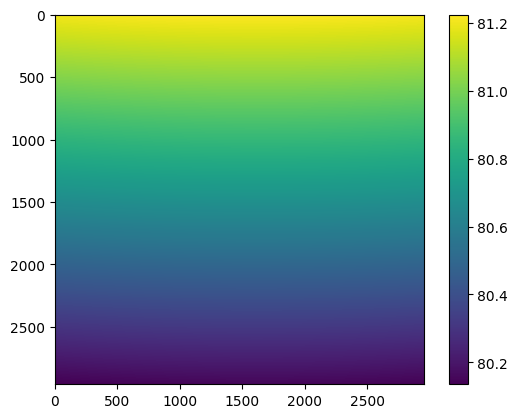

In [78]:
import matplotlib.pyplot as plt 

plt.imshow(lat)
plt.colorbar()
np.nanmin(lon), np.nanmin(lat)

In [106]:
cd C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid

C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid


In [22]:
%%time
a = Alignment(img1_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_1_of_subset_1_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif',
              img2_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_2_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif',
              displacement_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\drift\sub\subset_19-20_nov_drift_HV.csv',
              out_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\alignments2',
              geocoded=True)



Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
Done.


Estimating piecewise-affine transformation...
Done.

Warping C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub\subset_1_of_subset_1_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif
CPU times: total: 59 s
Wall time: 58 s


In [16]:
%%time
a = Alignment(img1_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub_3996\subset_1_of_subset_1_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif',
              img2_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\images\sub_3996\subset_2_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif',
              displacement_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\drift\sub_3996\subset_19-20_nov_drift_HV_projected.csv',
              out_path=r'C:\Anna\Icedrift\Chalmers\alignment_OOP\alignment_test_data\alignments3',
              geocoded=True,
              proj=3996)

Alignment method: piecewise-affine

Convert geocoded cooridnates to raster coordinates...
Done.


Estimating piecewise-affine transformation...


ValueError: Points cannot contain NaN

In [4]:
i_coords, j_coords = np.meshgrid(range(252), range(249), indexing='ij')
j_coords

array([[  0,   1,   2, ..., 246, 247, 248],
       [  0,   1,   2, ..., 246, 247, 248],
       [  0,   1,   2, ..., 246, 247, 248],
       ...,
       [  0,   1,   2, ..., 246, 247, 248],
       [  0,   1,   2, ..., 246, 247, 248],
       [  0,   1,   2, ..., 246, 247, 248]])

In [12]:
#open csv and add the columns x y instead of the previous

In [8]:
cd C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid

C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid


In [15]:
cd C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid

C:\Anna\Icedrift\Chalmers\alignment_OOP\ice_drift_pc_ncc\tools\geolocation_grid
